# Setup

In [ ]:
def colab_setup(is_colab=False):
    "Run if using Google Colab"
    if is_colab:
        from google.colab import drive
        drive.mount('/content/drive')
        %cd /content/drive/MyDrive/M4R/Homophily_Analysis/Homophily_Analysis
        !pip3 install dgl
        !pip3 install dgl-cu116 dglgo -f https://data.dgl.ai/wheels/repo.html
        !pip3 install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
        !pip3 install torch-geometric==2.1.0
        #%pip install dive-into-graphs
        #%pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html
    return

In [ ]:
%%capture
colab_setup(is_colab=True)

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pandas as pd
import torch_geometric
import warnings
from tqdm import tqdm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
warnings.simplefilter("ignore")
import dgl.data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [ ]:
from homophily_analysis_tools.datasets import *
from homophily_analysis_tools.spl_tools import *
from homophily_analysis_tools.homophily_metrics import *
from homophily_analysis_tools.gnn_models import *
from homophily_analysis_tools.generate_synthetic_graphs import *
from homophily_analysis_tools.plot_tools import *

In [ ]:
warnings.simplefilter("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Datasets

In [ ]:
dataset1 = NewCoraGraphDataset() 
g1 = dataset1[0]
G1 = nx.Graph(dgl.to_networkx(g1))

dataset2 = NewCiteseerGraphDataset() 
g2 = dataset2[0]
G2 = nx.Graph(dgl.to_networkx(g2))

dataset3 = NewPubmedGraphDataset()
g3 = dataset3[0]
G3 = nx.Graph(dgl.to_networkx(g3))

dataset4 = AmazonDatasetGraphDataset()
g4 = dataset4[1]
#G4 = nx.Graph(dgl.to_networkx(g4))

dataset5 = ActorGraphDataset()
g5 = dataset5[0]
G5 = nx.Graph(dgl.to_networkx(g5))

dataset6 = LINKXDatasetGraphDataset()
g6 = dataset6[0]
#G6 = nx.Graph(dgl.to_networkx(g6))


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


In [ ]:
n0 = 100
g0_homo = gen_complete_homophilic_graph(n0,k=10)
g0_hetero = gen_complete_heterophilic_graph(n0,k=10)

# Graph Plots

### Real

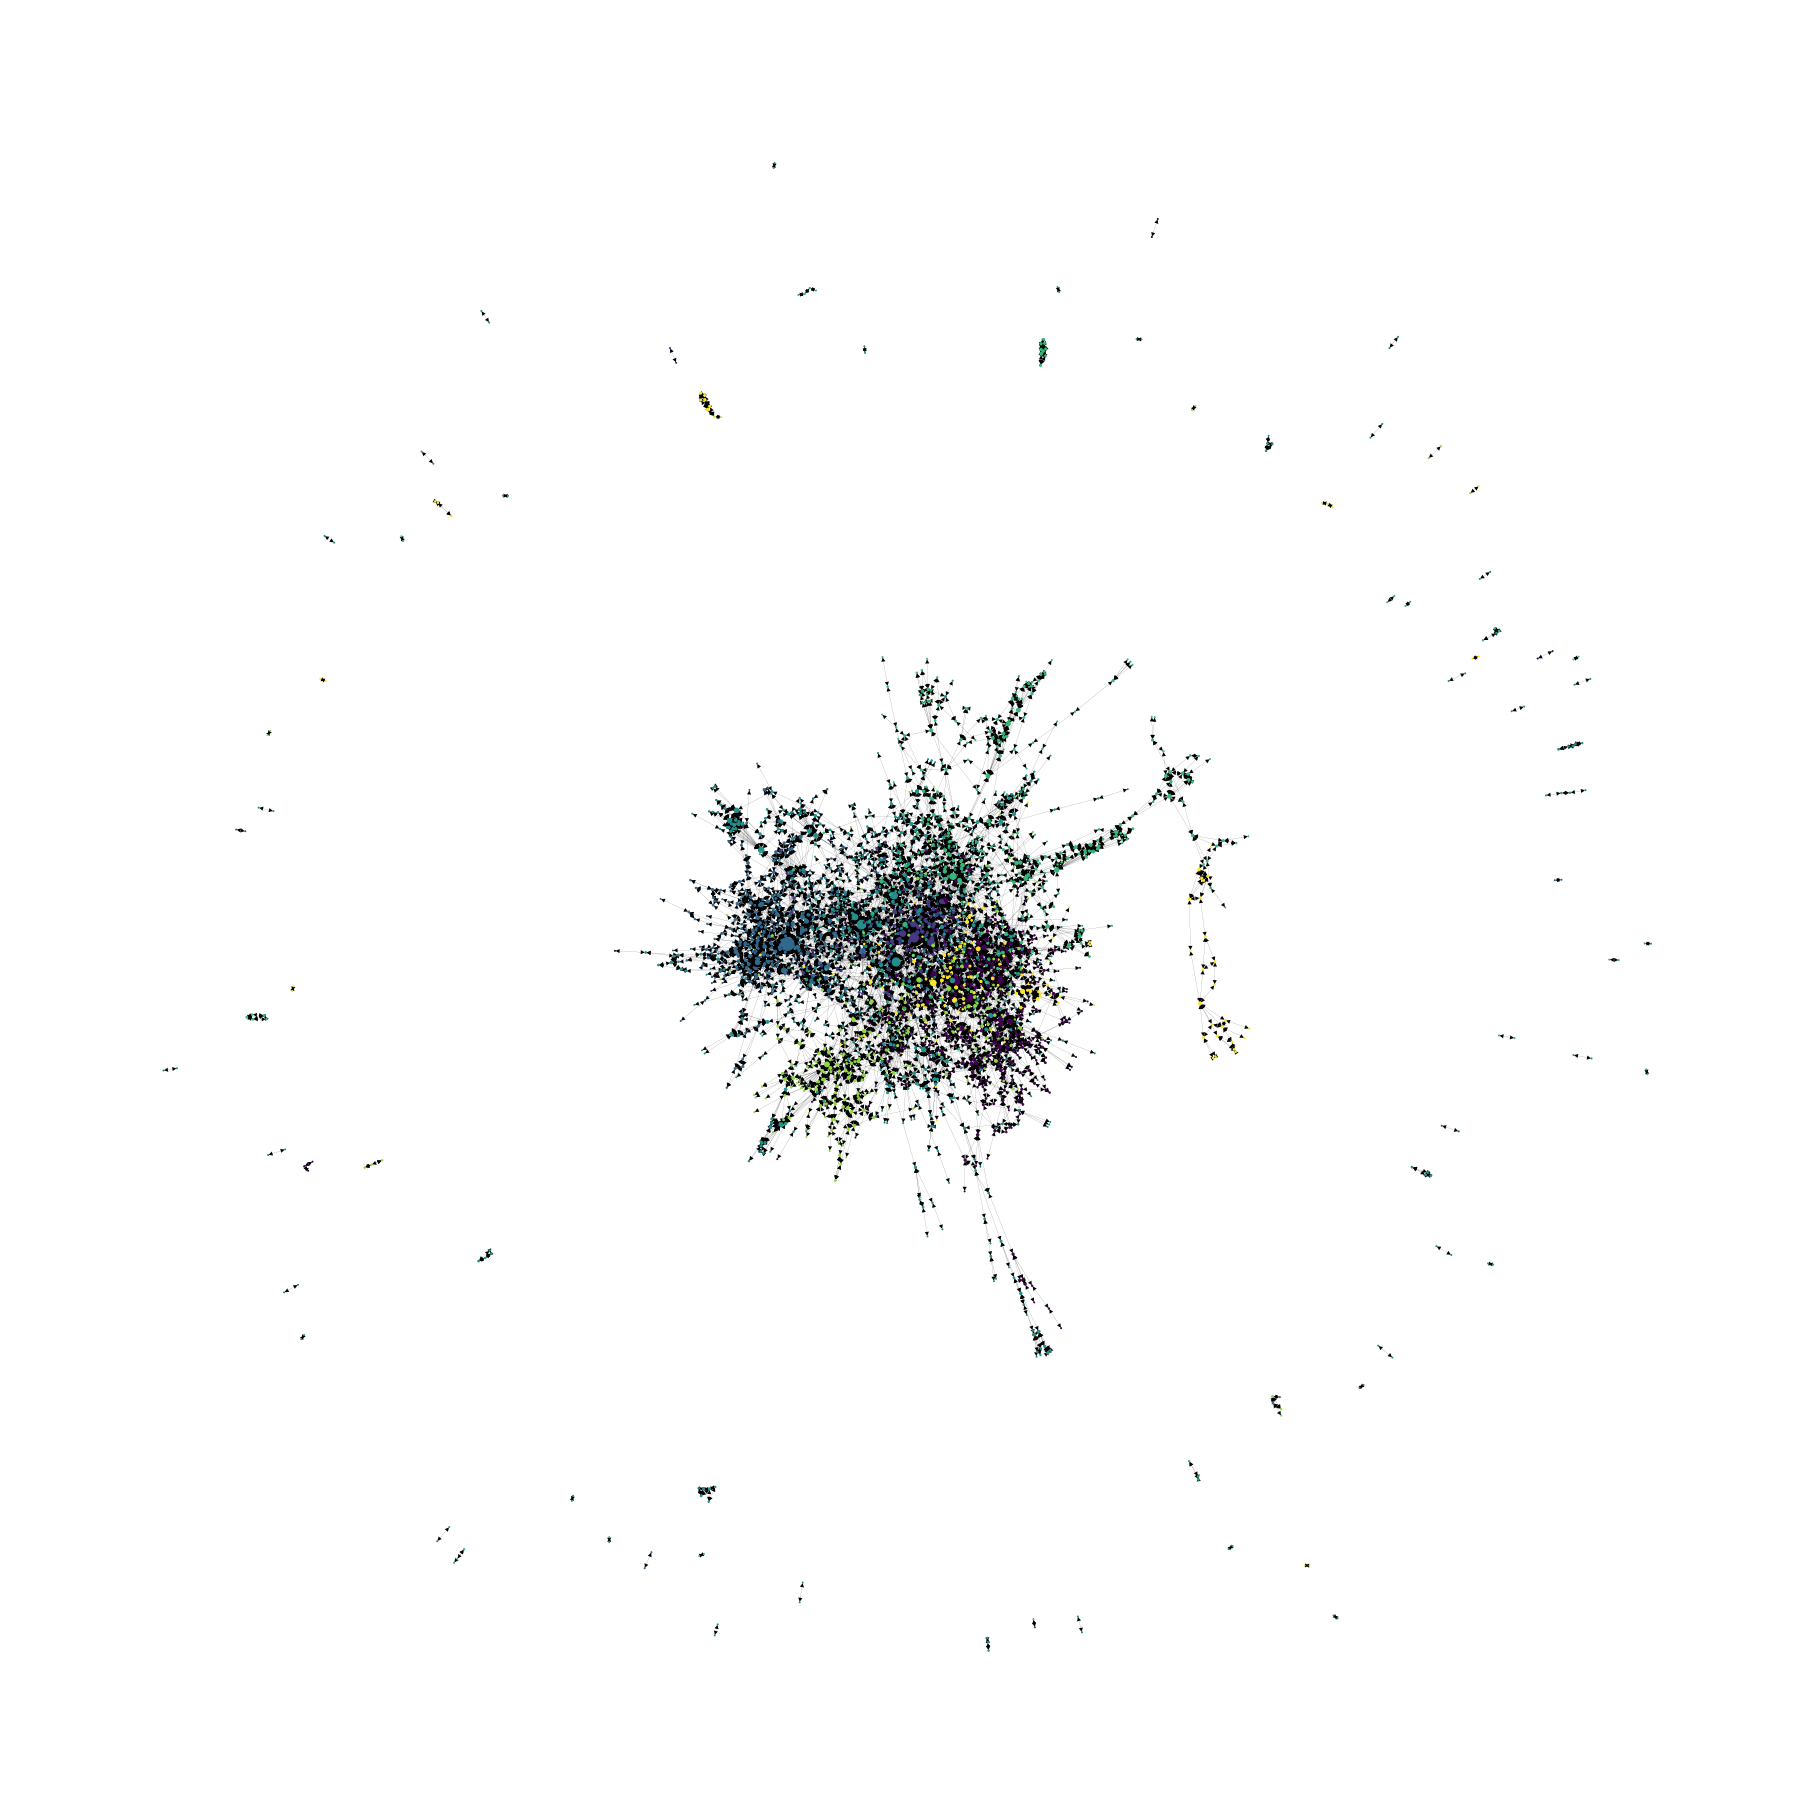

In [ ]:
plt.figure(1,figsize=(25,25)) 
nx.draw(g1.to_networkx(), alpha = 1, node_size = g1.in_degrees(), node_color = g1.ndata['label'], width=0.05)
plt.show()

### Generated

In [ ]:
g_SBM_synth_list = gen_synthetic_SBM_graph_list(g2,k=4,extreme_scale=10)

100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


In [ ]:
#g_synth_list = gen_synthetic_rewired_graph(g1,h=0.1)

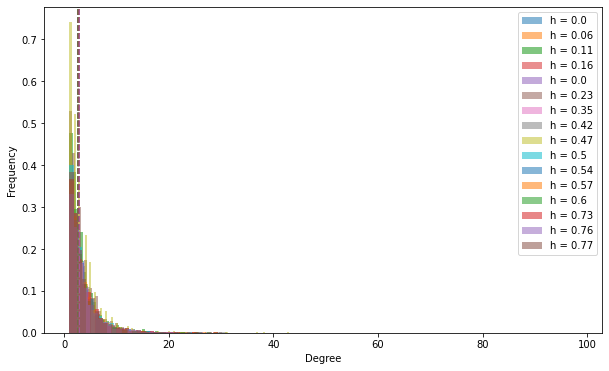

In [ ]:
plot_degree_distribution_comparison(g_SBM_synth_list)

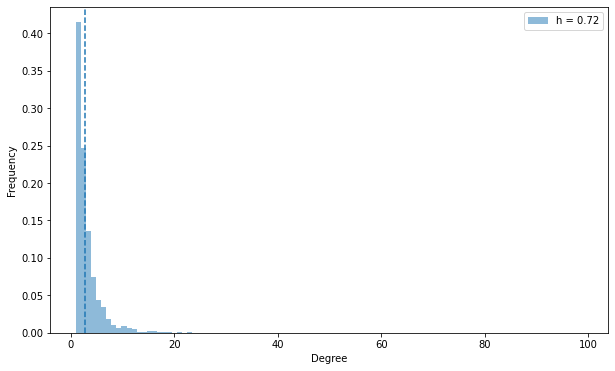

In [ ]:
plot_degree_distribution_comparison([g2])

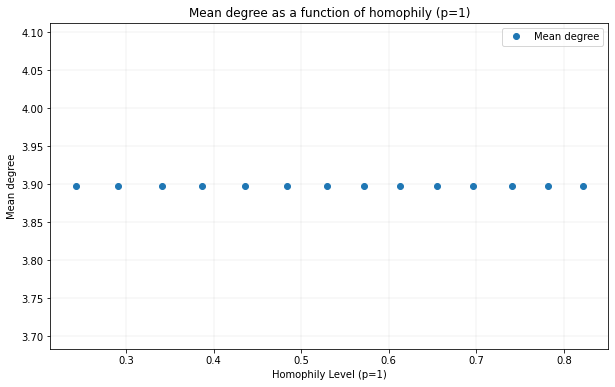

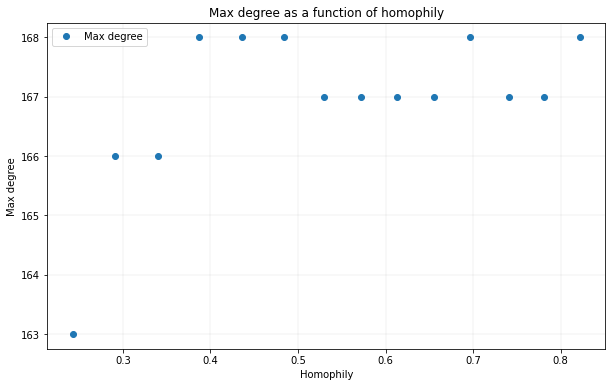

In [ ]:
plot_homophily_degree(g_synth_list,p=1)

In [ ]:
graph_summary(g_synth_list)

==================================================(GRAPH 1)==================================================
Eigenvalues:  [2.5097272, 2.6380582, 2.7183135, 3.0540025, 3.5142753, 3.7252936, 4.188419]
Leading Eigenvalue:  4.188418865203857
Mean Degree:  3.8980798721313477
Class Dist:  [0.12961595 0.08013294 0.15435746 0.30206794 0.15731166 0.11004432
 0.06646972]
Edge Homophily:  0.8098711967468262
Class Normalised Homophily:  0.8220469951629639
==================================================(GRAPH 2)==================================================
Eigenvalues:  [2.2894766, 2.465286, 2.4941456, 2.8368738, 3.330545, 3.532156, 4.1195292]
Leading Eigenvalue:  4.1195292472839355
Mean Degree:  3.8980798721313477
Class Dist:  [0.12961595 0.08013294 0.15435746 0.30206794 0.15731166 0.11004432
 0.06646972]
Edge Homophily:  0.7625047564506531
Class Normalised Homophily:  0.7815309166908264
==================================================(GRAPH 3)==========================================

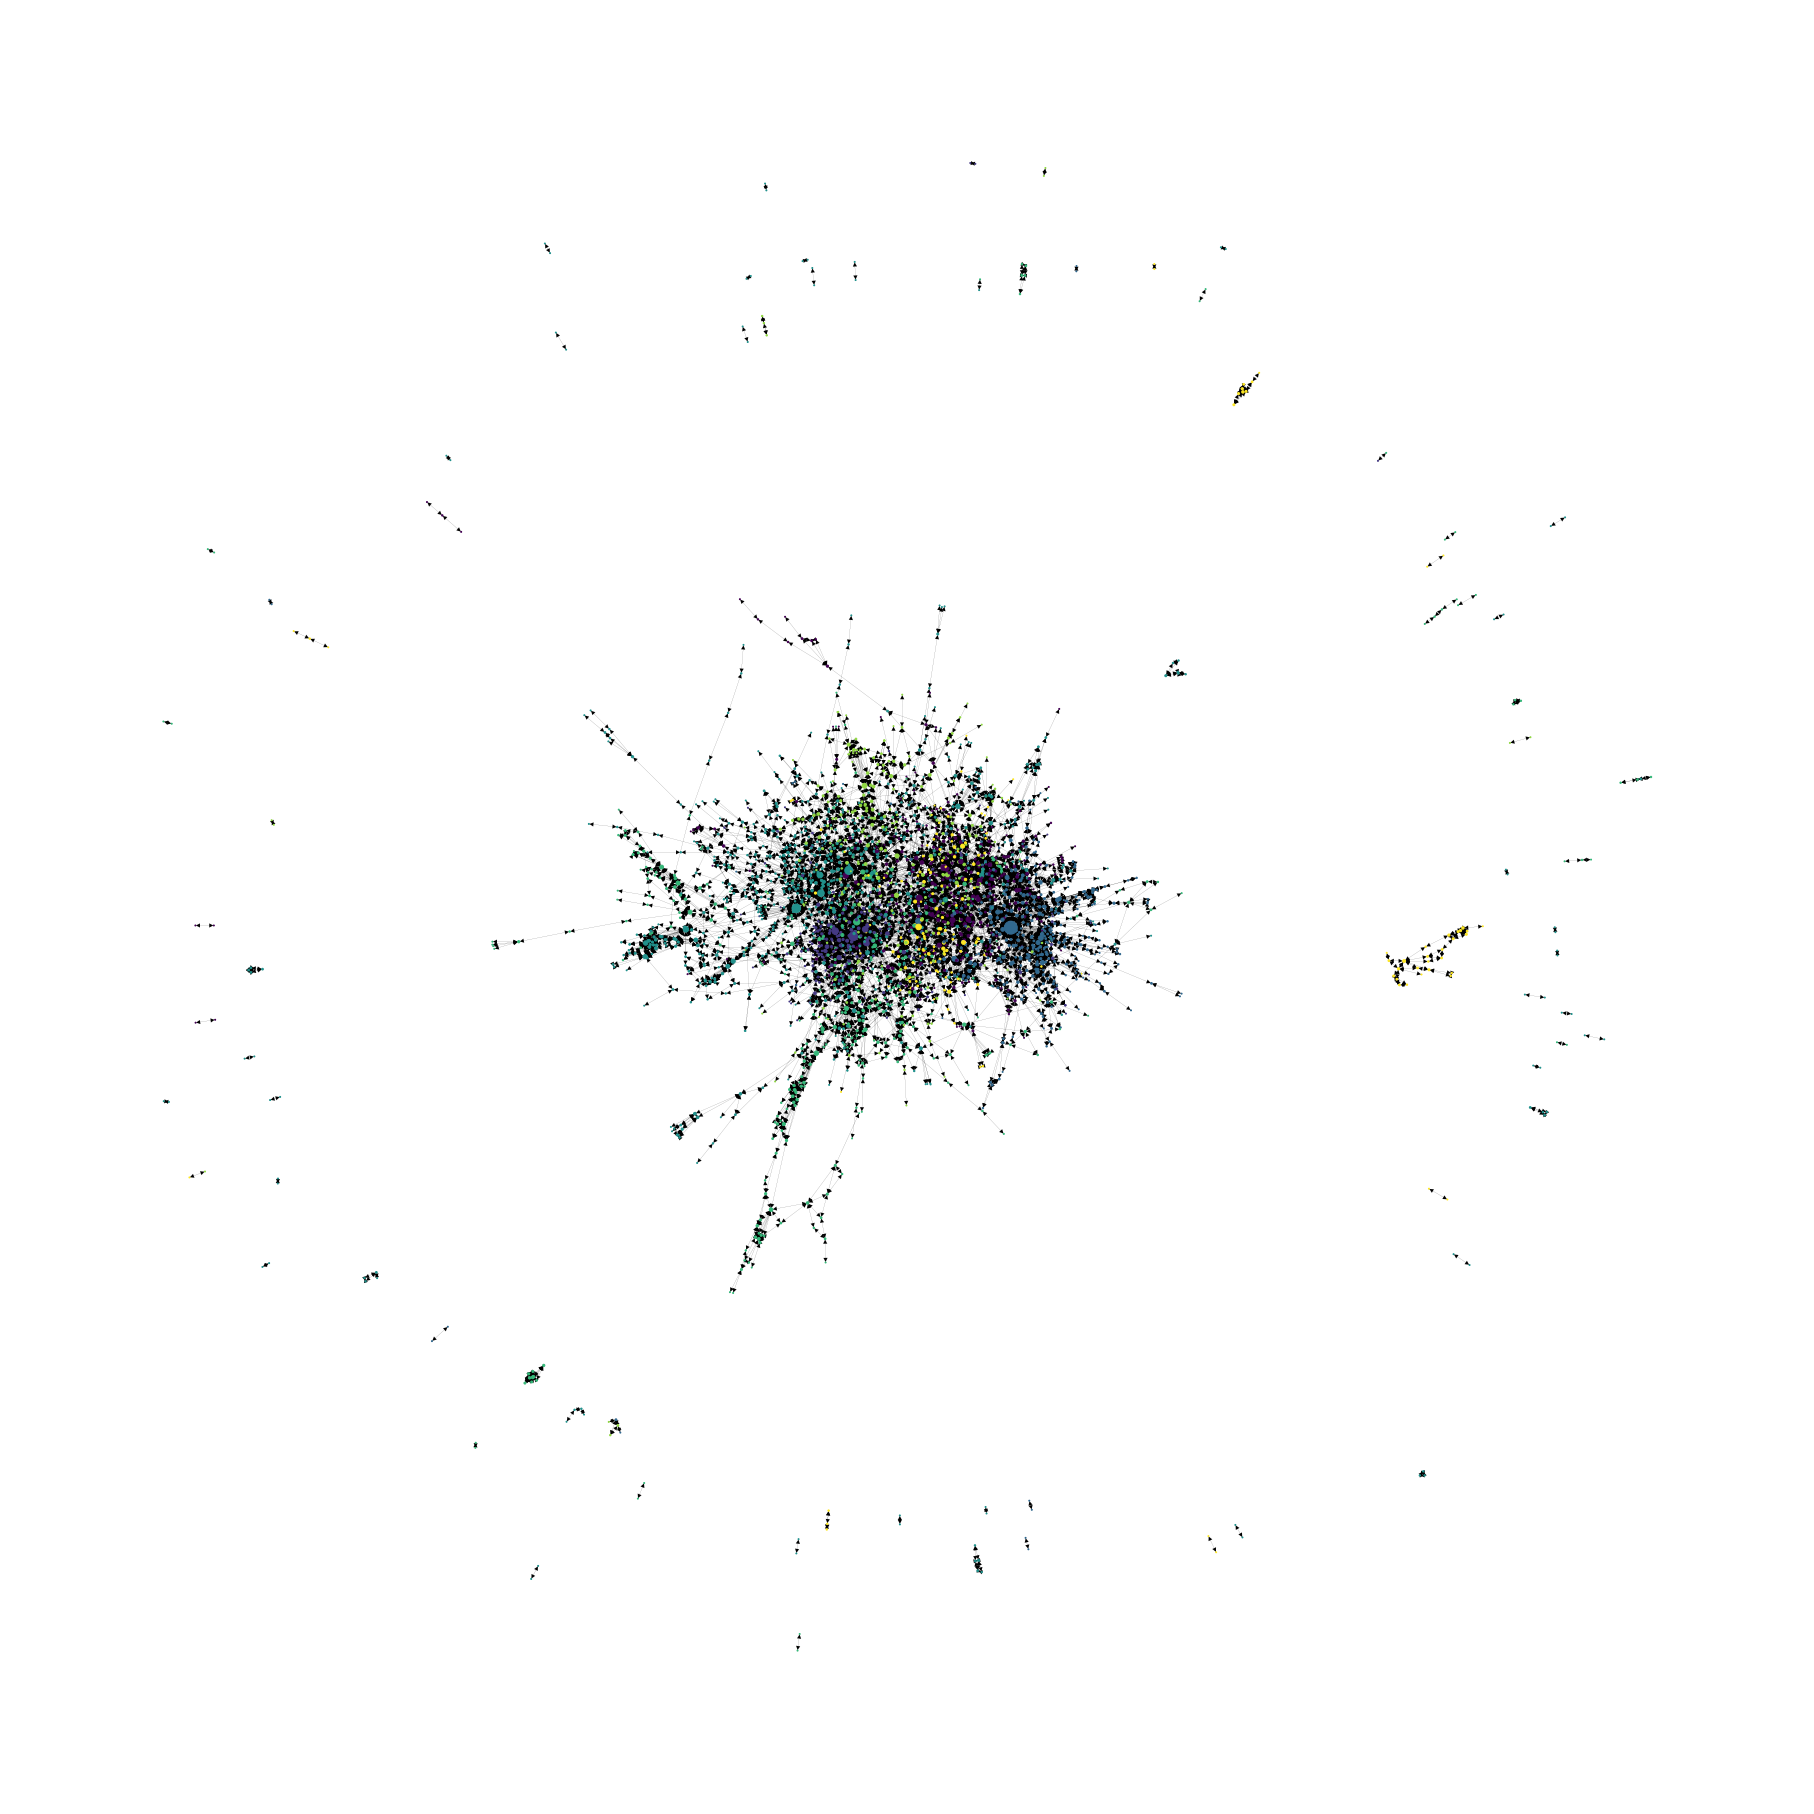

In [ ]:
plt.figure(1,figsize=(25,25))
g = g_synth_list[0]
nx.draw(g.to_networkx(), alpha = 1, node_size = g.in_degrees(), node_color = g.ndata['label'], width=0.05)
plt.show()

# Graph Summaries

In [ ]:
graph_summary([g0_homo,g0_hetero,g1,g2,g3,g4,g5])

==================================================(GRAPH 1)==================================================
Eigenvalues:  [5.9999995, 5.9999995, 6.999999, 6.999999, 6.999999, 9.0, 9.0, 13.0, 13.0, 13.0]
Leading Eigenvalue:  13.0
Mean Degree:  9.779999732971191
Class Dist:  [0.14 0.14 0.07 0.14 0.07 0.1  0.08 0.1  0.08 0.08]
Edge Homophily (p=1):  1.0
Node Homophily (p=1):  1.0000001192092896
Edge Homophily (p=2):  1.0
Node Homophily (p=2):  1.0
==================================================(GRAPH 2)==================================================
Eigenvalues:  [-16.562307, -14.2603, -11.000004, -10.387978, -9.407161, -8.379499, -7.4418287, -7.000001, -4.2527905, 88.69185]
Leading Eigenvalue:  88.69184875488281
Mean Degree:  88.54000091552734
Class Dist:  [0.16 0.11 0.11 0.09 0.1  0.04 0.07 0.07 0.08 0.17]
Edge Homophily (p=1):  0.0
Node Homophily (p=1):  0.0
Edge Homophily (p=2):  0.1111111119389534
Node Homophily (p=2):  0.12917585670948029
====================================

# Run Simuations

In [ ]:
g2_list,acc_list2,mean_spl_list2,mean_intra_spl_list2 = run_full_simulation(g2, mode='SBM',k=25)

Generating synthetic graphs...


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Testing GNN performance...


100%|██████████| 100/100 [03:31<00:00,  2.11s/it]


Calculating geodesics...


 99%|█████████▉| 99/100 [45:22<00:27, 27.56s/it]

In [17]:
torch.save(g2_list,'g2_list')
torch.save(mean_spl_list2,'mean_spl_list2')
torch.save(mean_intra_spl_list2,'mean_intra_spl_list2')
torch.save(acc_list2,'acc_list2')



# Plot Simulation Results

In [ ]:
g1_list = torch.load('g1_list')
mean_spl_list1 = torch.load('mean_spl_list1')
mean_intra_spl_list1 = torch.load('mean_intra_spl_list1')
acc_list1 = torch.load('acc_list1')

g1_r_list = torch.load('g1_list_rewired')
mean_spl_list1_r = torch.load('mean_spl_list1_rewired')
mean_intra_spl_list1_r = torch.load('mean_intra_spl_list1_rewired')
acc_list1_r = torch.load('acc_list1_rewired')

g5_list = torch.load('g5_list')
mean_spl_list5 = torch.load('mean_spl_list5')
mean_intra_spl_list5 = torch.load('mean_intra_spl_list5')
acc_list5 = torch.load('acc_list5')

g5_r_list = torch.load('g5_list_rewired')
mean_spl_list5_r = torch.load('mean_spl_list5_rewired')
mean_intra_spl_list5_r = torch.load('mean_intra_spl_list5_rewired')
acc_list5_r = torch.load('acc_list5_rewired')

g2_list = torch.


## General Results

Cora Dataset (Homophilic Seed Graph)- SBM generated



100%|██████████| 1/1 [00:16<00:00, 16.05s/it]


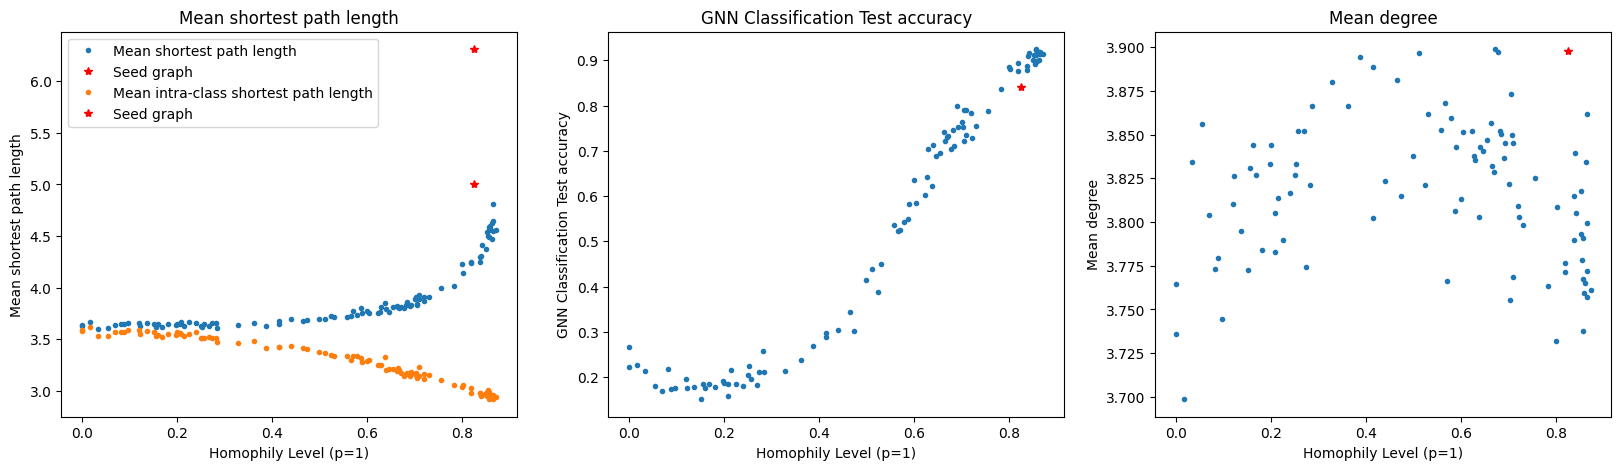

Actor Dataset (Heterophilic Seed Graph)- SBM generated



100%|██████████| 1/1 [00:29<00:00, 29.19s/it]


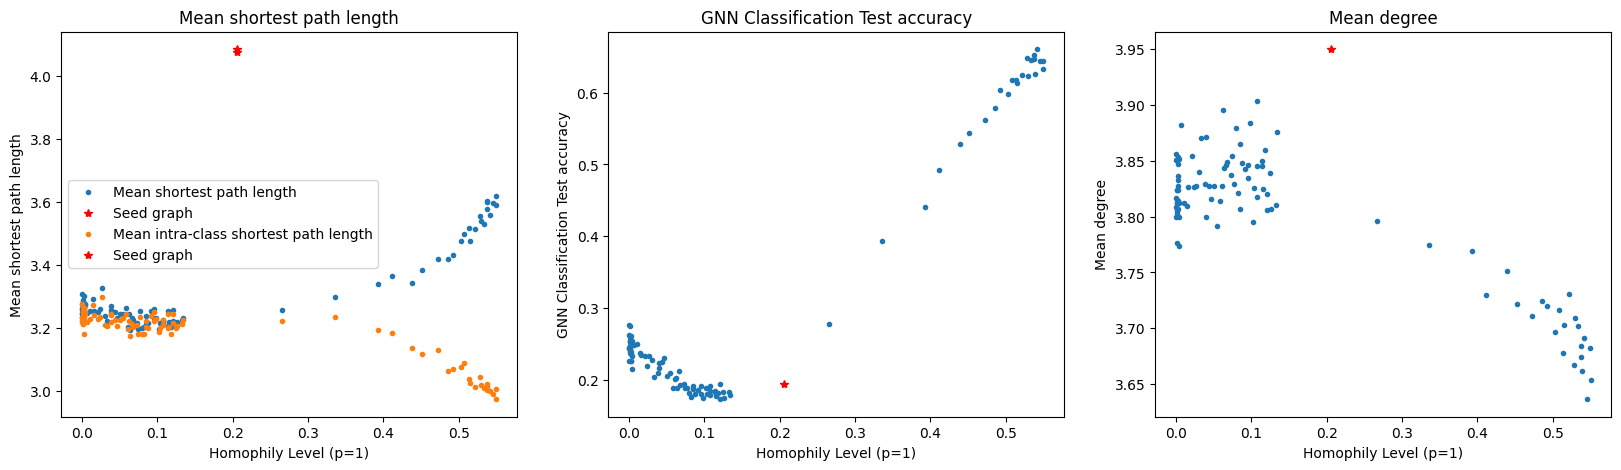

In [ ]:
print('='*100)
print('Cora Dataset (Homophilic Seed Graph)- SBM generated')
print('='*100+'\n')
do_plots_compact(g1_list,g1,mean_spl_list1,mean_intra_spl_list1,acc_list1,p=1)

print('='*100)
print('Actor Dataset (Heterophilic Seed Graph)- SBM generated')
print('='*100+'\n')
do_plots_compact(g5_list,g5,mean_spl_list5,mean_intra_spl_list5,acc_list5,p=1)


 ## Discussion of Results

 From these, results, we can make several important observations:
 1) **Mean Shortest Path Length**:
 We see that changing homophily through different methods of graph generation results in different behaviours of changes in mean shortest path length (SPL). Graphs generated through SBMs with smaller number of classes tend to have shorter geodesics than the seed graphs used to coarsen them, as indicated by the red markers which have a much higher mean SPL than their SBM-generated graphs with the same homophily. Despite SBM's shortcomings in modeling the mean SPL exactly, they do indeed manage to model *relative* geodesics. One example is the relative intra-class mean SPL: $\frac{<\lambda_{intra}>}{<\lambda>}$.  This is seen in the plots later, where the red markers for the seed graph lie perfectly on the curves plotted.

 2) **Graph Neural Network Classification Performance**
Even though SBM's fail to capture the exact geodesic behaviour of their respective seed graph, they still capture the general trend of Graph Neural Network Classifier Performance very well, assuming the degree distibution of the generated graphs is the same as that of the seed graph. This is is a very interesting discovery, and can be explained by the fact that GNN perfomance, which is strongly hindered by the emergence of bottlenecks, depends on edge curvature, which is a relative geodesic measure (see later on), hence can be modeled by SBMs.

3) **Degree Distrbution**
Whilst measures have been taken to ensure degree distribution remains the same for synthetic graphs generated from the same seed graph, by using degree correlated SBMs, the mean degree of the graphs produced varied slightly as homophily varied from that of the seed graph. This is because degree correlated SBMs can predict multi-edges between nodes, which have been combined in the final formation of the graph. By doing so, as homophily varied more significantly from that of the seed graph, the SBM predicted more multi-edges which were then cut out, causing the actual mean degree to be lower than it's expected value given by the degree correlated SBM.

# Intra-Class to Full SPL Ratio Plots

### Cora vs Actor Dataset (SBM generated)

100%|██████████| 1/1 [01:21<00:00, 81.29s/it]


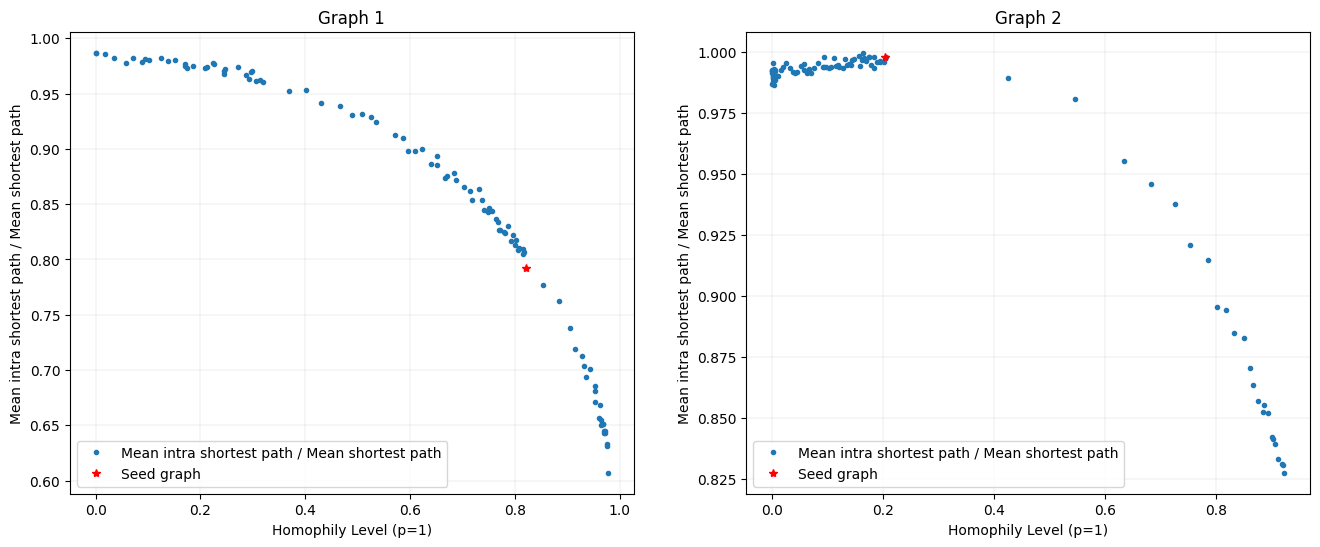

In [ ]:
plot_intra_full_spl_ratio_multiple([g1_list, g5_list], [g1,g5], [mean_spl_list1,mean_spl_list5], [mean_intra_spl_list1,mean_intra_spl_list5], p=1)

# P-Level Homophily vs GNN Performance

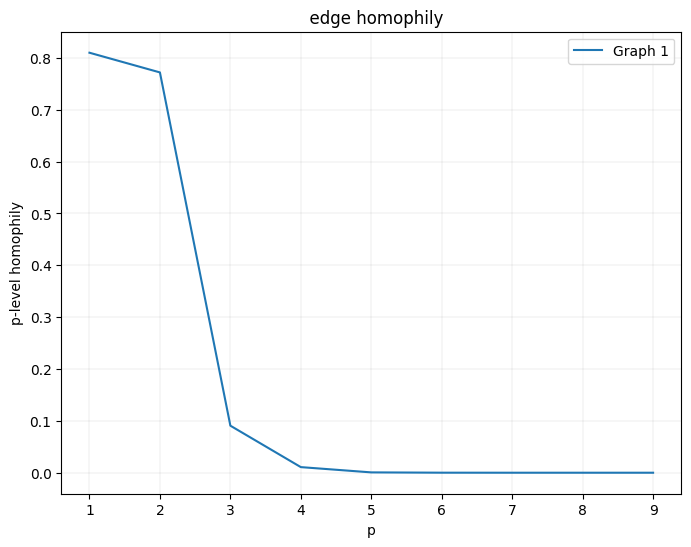

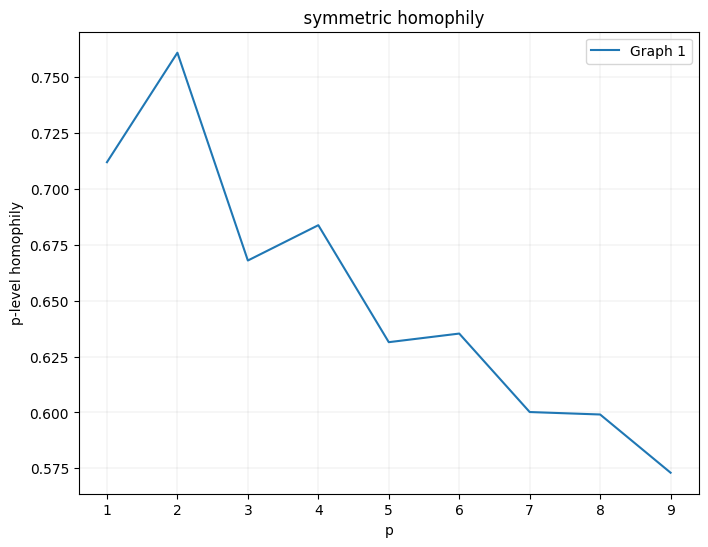

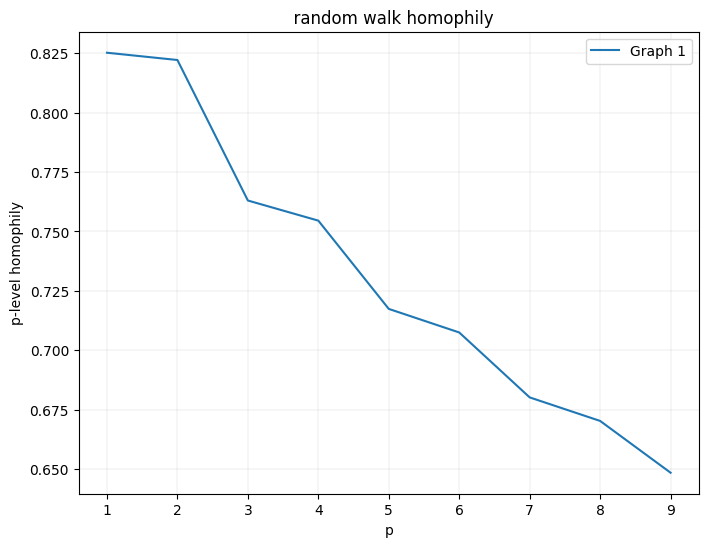

In [ ]:
plot_p_level_homophily([g1], homophily_type='edge')
plot_p_level_homophily([g1], homophily_type='symmetric')
plot_p_level_homophily([g1], homophily_type='random walk')



Cora Dataset (Homophilic Seed Graph)- SBM generated



100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


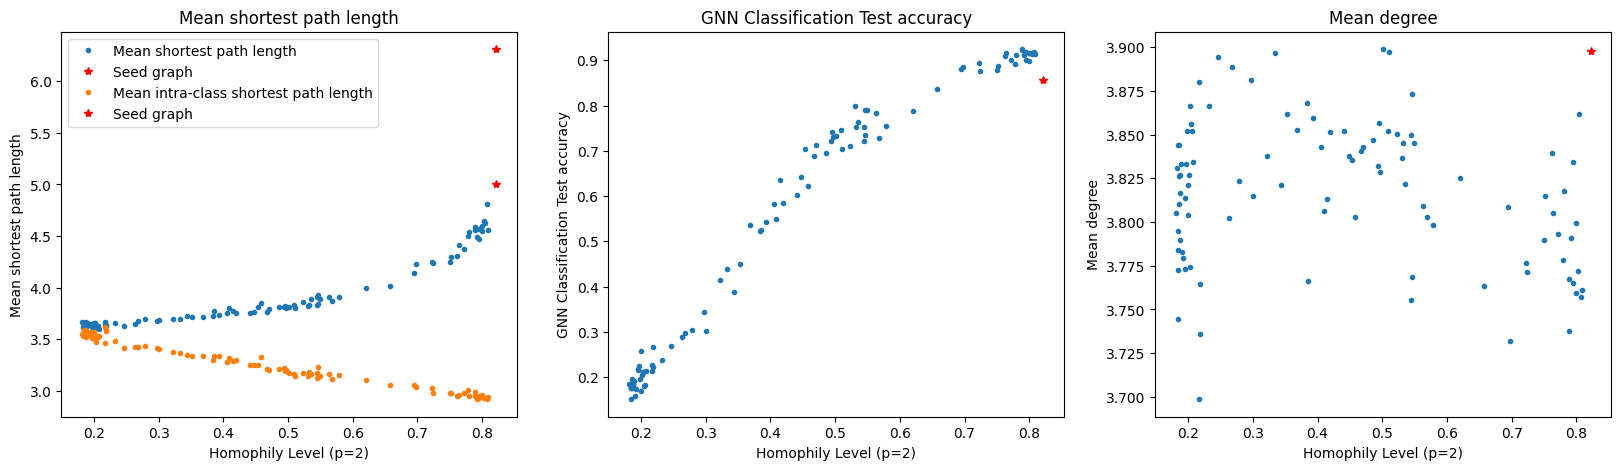

Actor Dataset (Heterophilic Seed Graph)- SBM generated



100%|██████████| 1/1 [00:42<00:00, 42.13s/it]


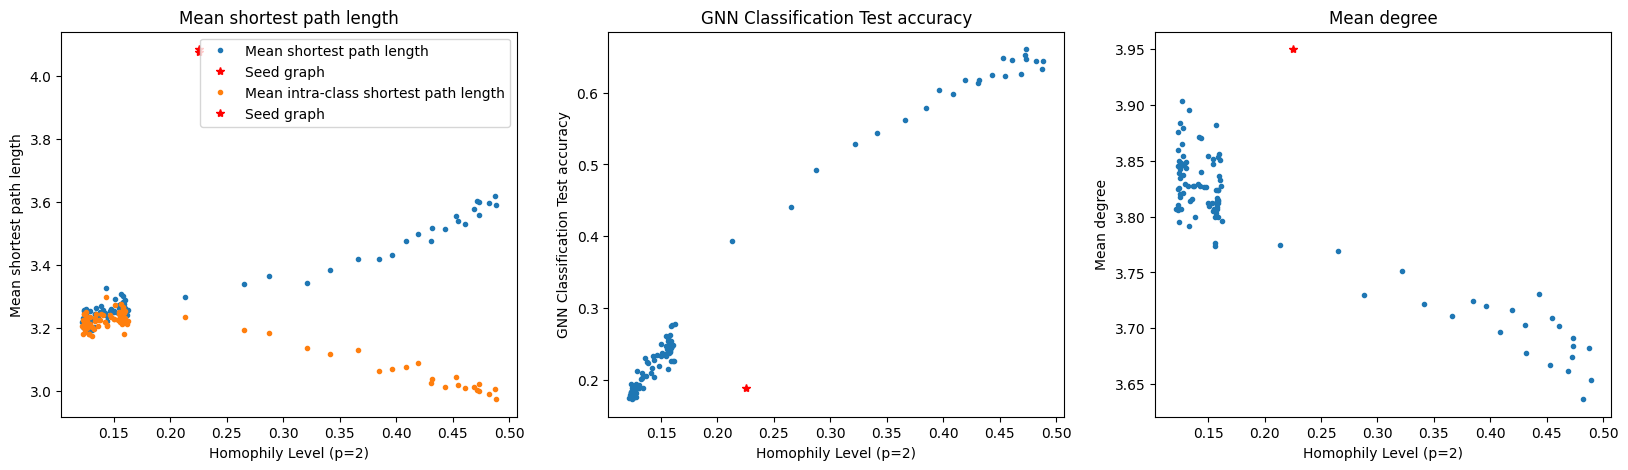

In [ ]:
print('='*100)
print('Cora Dataset (Homophilic Seed Graph)- SBM generated')
print('='*100+'\n')
do_plots_compact(g1_list,g1,mean_spl_list1,mean_intra_spl_list1,acc_list1,p=2)

print('='*100)
print('Actor Dataset (Heterophilic Seed Graph)- SBM generated')
print('='*100+'\n')
do_plots_compact(g5_list,g5,mean_spl_list5,mean_intra_spl_list5,acc_list5,p=2)


In the case of the graphs generated from the Actor graph dataset, the dicrepency between performance of the seed graph to that of it's generated graphs with the same homophily can be explained by the significantly higher mean degree of the seed graph. This is caused by the fact that the seed graph is highly heterophilic, and so attempting to generate graphs from it with higher homophily results in many multi-edge predictions at high homophily levels, which are cut off causing lower mean degrees than the expected value given by the model.

# How Homophily Affects GNN Performance + Next Steps

### Global Scale

In litterature, node homophily is defined as the mean number of neighbours of a node of the same class over the node's total number of neighbours:
$$h = \frac{1}{n}\sum_{i=1}^{n} \frac{|\{ j \sim i| y_i = y_j\}|}{d_i}$$

This can be rewritten as:
$$h = \frac{1}{n}\sum_{k=1}^{K} \sum_{i,j \in C_k} \hat{A}_{ij}$$

Where $\hat{A} = D^{-1}A$ is the random walk normalied adjacency matrix. Note that an alternative node homophily metric can be defined on the symmetric normalised adjacency matrix $\hat{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$, and provides equivilant results for related classes of GNNs.

P-Level homophily generalises the above metric to p-hop neighbourhoods, and is defined as:

$$h^{(p)} = \frac{1}{n}\sum_{k=1}^{K} \sum_{i,j \in C_k} \hat{A}_{ij}^p$$

P-Level homophily is much a better measure of GNN performance as it can be proven to bound the intra-class information flow of simple GNN models following the update rule: 
$$H^{(l+1)}_i = \frac{1}{deg(i)} \sum_{i \sim j} \psi(H_j^{(l)}), \quad \psi'(x)< \alpha \quad  \forall x $$
The upper bound for such GNN models is given by:

$$\frac{1}{n}\sum_{k=1}^{k}\sum_{i,j \in C_k} |\frac{\partial H_i^{(p)}}{\partial X_j}| < h^{(p)} \alpha^{p}$$

The chosen model in this analysis is a 2-layer GCN, with ReLU activation functions between layers. For this model, $h^{(2)}$ is a good bound on it's intra-class information flow.  In the plots above, we see that $h^{(2)}$ represents the GNN performance much better, as the U-shape curve from using $h^{(1)}$ is gone.

From a global view, this proves that homophily controls information flow between nodes of the same class, which at low levels creates bottlenecks of essential information, as GNNs act similar to laplacian smoothers, hence require information from nodes of the same class in order to make accurate prediction. 

### Local Scale

Modeling information flow on a local scale however is much more useful for practical purposes, when attempting to alleviate bottlenecks. This local view is obtained by looking at *Edge Curvature*. Topping et. al. proved that Balanced Forman Curvature provides a bound on local information flow:

**Theorem:**

Let $Ric(i,j)$ be the Balanced Forman Corvature of edge (i,j). If there exists a $0<\delta<max(d_i,d_j)^{-\frac{1}{2}}$, $\delta <\gamma_{max}^{-1}$ such that $Ric(i,j)\leq-2+\delta$, then there exists $Q_j \subset S_2(i)$ satisfying $|Q_j|>\delta^{-1}$, for which we have:

$$\frac{1}{|Q_j|} \sum_{k \in Q_j} |\frac{\partial H_k^{(2)}}{\partial X_i}| < a^2 \delta^{\frac{1}{4}}$$

The definition of Balanced Forman Curvature is combinatorial in nature, and involves quantities such as number of traingles and squares with edge (i,j). It is related however to Ollivier Curvature, given by 1 minus the transportation distance of nodes i and j, which is calculated using the geodesic distance of nodes in the neighbourhood of both nodes i and j:

$$\kappa^{\alpha}(i,j) = 1- \frac{\inf_M \sum_{r \sim i, s \sim j} M_{rs}^{\alpha} d(r,s)}{d(i,j)}$$

This can be thought of as a form of minimally weighted mean of graph geodesic lengths between neighbours of i and j, relative to the geodesic length of i and j.

Ollivier Curvature is given by:
$$\kappa(i,j) = \lim_{\alpha \to 0} \frac{\kappa^{\alpha}(i,j)}{1-\alpha}$$

Here, the infinum is taken over all matricies M satisfying:

$$\sum_{k \sim i} M_{k w} = \mu_j^{\alpha}(w), \quad \sum_{w \sim j} M_{k w} = \mu_i^{\alpha}(k)$$

Where $\mu^{\alpha}$ is a probability measure given by:

$$\mu^{\alpha}_i(j) = \begin{cases} \alpha & \text{if } j=i \\ \frac{1-\alpha}{d_i} & j \sim i \\ 0 & \text{otherwise }\end{cases}$$

Ollivier curvature is related to balanced forman curvature by:

$$Ric(i,j) \leq \kappa(i,j)$$

**Goal:**

Using all of this, the goal would be to model edge curvature between nodes of the same class, by coarsening to a (potentially degree correlated) SBM and using the approximate shortest path length distribution to calculate expected edge curvature between specific nodes i and j of the same class. This would allow us to measure how homophily, which is embedded into the SBM model, affects information flow between individual nodes i and j of the same class. 

This would allow us to potentially build better curvature based graph rewiring methods such as the one introduced by Topping et. al., with the clearer target of specifically alleviating negative edge curvature between nodes of the same class.